# **Указание авторства книг жанра фэнтези**

В данном исследовании представлена модель, которая классифицирует данные по авторам в жанре фэнтези. 

Исследование поделено на две части. В первой части мы собираем и подготавливаем данные для последующей загрузки в модель. Во второй части мы проводим необходимый анализ текста для выполнения задачи классификации. 

Вторая часть (Блок 2) состоит из трех независимых друг от друга частей. В каждой используются свои решения задачи классификации.

Цель работы заключается в создании модели-классификатора указания авторства в книгах жанра фэнтези.

Задачи: 

1) Собрать необходимые данные

2) Провести препроцессинг данных и подготовить их к анализу

3) Создать модель-классификатор

4) Провести анализ полученных результатов

# **Блок 1**

# **Сбор и подготовка данных**

Для нашего исследования мы взяли 5 из самых популярных произведений в жанре фэнтези:

1) Дж. Р. Р. Толкин "Властелин колец"

2) А. Сапковский "Последнее желание. Меч предназначения"

3) Дж. Мартин "Игра престолов"

4) Р. Желязны "Хроники Амбера"

5) Н. Гейман "Американские боги"

Мы создадим датасет, в котором у нас будут содержаться данные для решения задачи классификации предложений по авторству из исходных текстов.

In [ ]:
# импортируем все необходимые библиотеки

import glob
import nltk
from nltk import tokenize, download
import numpy as np
import random
import pandas as pd
import string
import time
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.stem.porter import PorterStemmer
from typing import List
from collections import Counter

from typing import List

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer

import keras
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import one_hot
from keras.callbacks import ModelCheckpoint 

from scipy import stats


Из библиотеки NLTK загружаем модуль "Punkt"

Этот токенизатор нужен нам для деления текста на список предложений, используя неконтролируемый алгоритм для построения модели слов-аббревиатур, словосочетаний и слов, с которых начинаются предложения.

In [ ]:
download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

С помощью функции ниже мы создадим список предложений, длина которых более 5 символов, так как предполагаем, что более короткие, скорее всего, не несут полезной для нас информации.

Чтобы наш токенизатор работал корректнее, мы заменяем некторые комбинации символов в тексте для того, чтобы отделять реплики от речи авторов и чтобы корректно интерпретировать кавычки.

In [ ]:
def split_text(filepath: str, min_char: int = 5) -> List[str]:
    
    text = str()
    with open(filepath, "r", encoding="utf8") as file:
        text = file.read().replace('\n', '. ')
        text = text.replace('.”', '”.').replace('."', '".').replace('?”', '”?').replace('!”', '”!')
        text = text.replace('--', ' ').replace('. . .', '').replace('_', '')
    
    sentences = tokenize.sent_tokenize(text)    
    sentences = [sentence for sentence in sentences if len(sentence) >= min_char]

    return list(sentences)

Ниже для каждого автора мы создадим список предложений из их произведений.

In [ ]:
gaiman = []
for path in glob.glob('/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Гейман Американские боги.txt'):
    gaiman += split_text(path)
    
zelazny = []
for path in glob.glob('/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Желязны Хроники Амбера.txt'):
    zelazny += split_text(path)

martin = []
for path in glob.glob('/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Мартин Игра престолов.txt'):
    martin += split_text(path)
    
sapkowski = []
for path in glob.glob('/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Сапковский Последнее желание Меч предназначения.txt'):
    sapkowski += split_text(path)

tolkien = []
for path in glob.glob('/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Толкин Властелин колец.txt'):
    tolkien += split_text(path)

Ниже мы видим, сколько у каждого автора в произведении предложений. 

In [ ]:
text_dict = { 'Gaiman': gaiman, 'Zelazny': zelazny, 'Martin': martin, 'Sapkowski': sapkowski, 'Tolkien': tolkien }

for key in text_dict.keys():
    print(key, ':', len(text_dict[key]), ' предложений (sentences)')

Gaiman : 12756  предложений (sentences)
Zelazny : 20281  предложений (sentences)
Martin : 20022  предложений (sentences)
Sapkowski : 21835  предложений (sentences)
Tolkien : 41323  предложений (sentences)


Каждый наш список содержит от 12 756 до 41 323 предложений. Для равного распредления мы ограничим списки до 10 000 предложений на автора.

In [ ]:
np.random.seed(1)

max_len = 10_000

names = [gaiman, zelazny, martin, sapkowski, tolkien]

combined = []
for name in names:
    name = np.random.choice(name, max_len, replace=False)
    combined += list(name)

print('Длина скомбинированного и перетасованного списка:', len(combined))

Длина скомбинированного и перетасованного списка: 50000


Здесь мы укажем метки авторов для предложений.

In [ ]:
labels = ['Gaiman'] * max_len + ['Zelazny'] * max_len + ['Martin'] * max_len + ['Sapkowski'] * max_len + ['Tolkien'] * max_len

print('Длина списка:', len(labels))

Длина списка: 50000


Проверим, что количество скомбинированных предложений совпадает с авторами.

In [ ]:
len(combined) == len(labels)

True

Перемешиваем данные в случайном порядке.

In [ ]:
random.seed(5)

zipped = list(zip(combined, labels))
random.shuffle(zipped)
combined, labels = zip(*zipped)

Посмотрим на получившийся датафрейм.

In [ ]:
out_data = pd.DataFrame()
out_data['text'] = combined
out_data['author'] = labels
print(out_data.head())
print(out_data.tail())

                                                text   author
0  Тысячи лет пираты с Железных Островов — железн...   Martin
1  И на сей раз на него нахлынул приступ ярости, ...   Gaiman
2                                  И ответа не было.   Gaiman
3  Любопытство мое было подогрето до такой степен...  Tolkien
4       Пламя лизало камень злыми красными язычками.   Martin
                                                    text   author
49995  Потом я разглядел, что у нее в левой руке, и б...  Zelazny
49996                      Знал, наверное, еще как знал!  Tolkien
49997  Он вытер руки о джинсы и протянул Тени могучую...   Gaiman
49998            А потом сказала с неуверенной улыбкой:.   Gaiman
49999  Кто-то заметил на дереве краснохвостого ястреб...   Gaiman


In [ ]:
text = combined
author = labels

Экспортируем датафрейм в формате .csv таблицы.

In [ ]:
out_data.to_csv('data.csv', index=False)

У нас есть датафрейм со столбцами "text" и "author" и перемешанными в нем предложениями, соответствующими авторам.

Теперь займемся анализом необработанных данных и чисткой текста.

In [ ]:
data = pd.read_csv('data.csv', encoding='utf8')
print(data.head())
print(data.tail())

                                                text   author
0  Тысячи лет пираты с Железных Островов — железн...   Martin
1  И на сей раз на него нахлынул приступ ярости, ...   Gaiman
2                                  И ответа не было.   Gaiman
3  Любопытство мое было подогрето до такой степен...  Tolkien
4       Пламя лизало камень злыми красными язычками.   Martin
                                                    text   author
49995  Потом я разглядел, что у нее в левой руке, и б...  Zelazny
49996                      Знал, наверное, еще как знал!  Tolkien
49997  Он вытер руки о джинсы и протянул Тени могучую...   Gaiman
49998            А потом сказала с неуверенной улыбкой:.   Gaiman
49999  Кто-то заметил на дереве краснохвостого ястреб...   Gaiman


Убедимся, что у нас получилось равномерное распределение предложений по авторам.

In [ ]:
authors = Counter(author)
authors

Counter({'Martin': 10000,
         'Gaiman': 10000,
         'Tolkien': 10000,
         'Zelazny': 10000,
         'Sapkowski': 10000})

Теперь выведем статистику по словам и символам в предложениях.

In [ ]:
word_count = np.array([len(sent.split()) for sent in text])
char_count = np.array([len(sent) for sent in text])
ave_length = char_count / word_count

In [ ]:
def get_stats(var):    
    print('\t Min: ', np.min(var))
    print('\t Max: ', np.max(var))
    print('\t Average: ', np.mean(var))
    print('\t Median: ', np.median(var))

print('Статистика количества слов:')
get_stats(word_count)

Статистика количества слов:
	 Min:  1
	 Max:  151
	 Average:  12.16234
	 Median:  9.0


Визуализируем нашу статистику. Начем с количества слов в предложении.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 100.0)

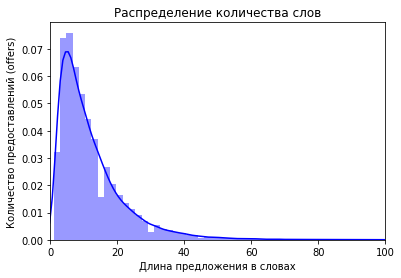

In [ ]:
sns.distplot(word_count, kde=True, bins=80, color='blue').set_title('Распределение количества слов')
plt.xlabel('Длина предложения в словах')
plt.ylabel('Количество предоставлений (offers)')
plt.xlim(0, 100)

Теперь сделаем все то же самое, но не для слов, а для символов.

In [ ]:
print('Статистика количества символов:')
get_stats(char_count)

Статистика количества символов:
	 Min:  5
	 Max:  1012
	 Average:  74.381
	 Median:  55.0


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 400.0)

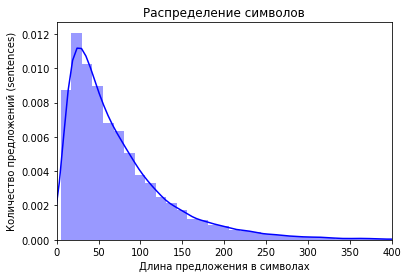

In [ ]:
sns.distplot(char_count, kde=True, bins=80, color='blue').set_title('Распределение символов')
plt.xlabel('Длина предложения в символах')
plt.ylabel('Количество предложений (sentences)')
plt.xlim(0, 400)

Посмотрим на среднюю длину слова. Это отношение количества символов к количеству слов.

In [ ]:
print('Средняя длина:')
get_stats(ave_length)

Средняя длина:
	 Min:  2.0
	 Max:  26.0
	 Average:  5.999245826010186
	 Median:  6.0


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 10.0)

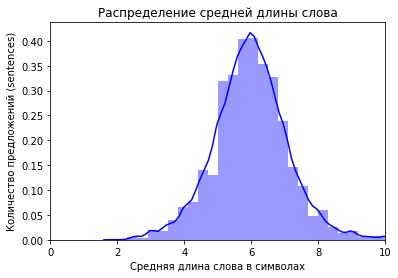

In [ ]:
sns.distplot(ave_length, kde=True, bins=80, color='blue').set_title('Распределение средней длины слова')
plt.xlabel('Средняя длина слова в символах')
plt.ylabel('Количество предложений (sentences)')
plt.xlim(0, 10)

Теперь, когда мы посмотрели всю интересующую нас статистику, мы можем заняться чисткой данных.

Первым делом избавимся от пробелов и отступов, которые интерпретируются неправильно.

In [ ]:
text = [excerpt.replace('\xa0', '').replace('\x7f', '') for excerpt in text]

In [ ]:
ctr = 0
for excerpt in text:
    if '  ' in excerpt:
        ctr += 1

print(ctr, 'больших отступов')

8218 больших отступов


In [ ]:
new_text = []
for excerpt in text:
    while '  ' in excerpt:
        excerpt = excerpt.replace('  ',' ')
    new_text.append(excerpt)

text = new_text
print(len(text))

50000


Удаляем пунктуацию и переводим предложения в нижний регистр.

In [ ]:
normed_text = []

for sent in text:
    new = sent.lower()
    new = new.translate(str.maketrans('','', string.punctuation))
    new = new.replace('“', '').replace('”', '')
    new = new.replace('‟', '').replace('”', '')
    new = new.replace('«', '').replace('»', '')
    new = new.replace('—', '').replace('–', '')
    new = new.replace('(', '').replace(')', '')
    new = new.replace('…', '')
    
    normed_text.append(new)

Экспортируем обработанные данные так же в формате .csv таблицы.

In [ ]:
data['text'] = normed_text
data.to_csv('preprocessed_data.csv', index=False)
print(data.head())
print(data.tail())

                                                text   author
0  тысячи лет пираты с железных островов  железны...   Martin
1  и на сей раз на него нахлынул приступ ярости г...   Gaiman
2                                   и ответа не было   Gaiman
3  любопытство мое было подогрето до такой степен...  Tolkien
4        пламя лизало камень злыми красными язычками   Martin
                                                    text   author
49995  потом я разглядел что у нее в левой руке и быс...  Zelazny
49996                         знал наверное еще как знал  Tolkien
49997  он вытер руки о джинсы и протянул тени могучую...   Gaiman
49998              а потом сказала с неуверенной улыбкой   Gaiman
49999  ктото заметил на дереве краснохвостого ястреба...   Gaiman


У нас получился готовый датафрейм, с которым можно работать и загружать в нашу будущую модель. 

# **Блок 2**

# **Анализ текста и выполнение задачи классификации**

# Способ 1

# N-граммы: сложный и долгий метод

Импортируем наши обработанные данные.

In [ ]:
data = pd.read_csv('preprocessed_data.csv', encoding='utf8')

In [ ]:
print(data.head())
print(data.tail())

                                                text   author
0  тысячи лет пираты с железных островов  железны...   Martin
1  и на сей раз на него нахлынул приступ ярости г...   Gaiman
2                                   и ответа не было   Gaiman
3  любопытство мое было подогрето до такой степен...  Tolkien
4        пламя лизало камень злыми красными язычками   Martin
                                                    text   author
49995  потом я разглядел что у нее в левой руке и быс...  Zelazny
49996                         знал наверное еще как знал  Tolkien
49997  он вытер руки о джинсы и протянул тени могучую...   Gaiman
49998              а потом сказала с неуверенной улыбкой   Gaiman
49999  ктото заметил на дереве краснохвостого ястреба...   Gaiman


In [ ]:
normed_text = list(data['text'])
author = list(data['author'])

authors_names = list(Counter(author).keys())
authors_count = len(authors_names)

normed_text = [str(i) for i in normed_text]

Пропишем функции, с помощью которых мы сможем построить графики для матрицы ошибок, точности и потерь.

In [ ]:
def plot_confusion_matrix(cm, classes: List[str],
                          normalize: bool = False,
                          title: str = 'Confusion Matrix',
                          cmap = plt.cm.Greens):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Unnormalized confusion matrix')

    print(cm)
       
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sns.heatmap(df_cm, annot=True, cmap = cmap)
    plt.ylabel('Right author')
    plt.xlabel('Predicted author')
    plt.title(title)

In [ ]:
def plot_history_of_accurancy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['teaching data', 'test data'], loc='upper left')

In [ ]:
def plot_history_of_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model error')
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.legend(['teaching data', 'test data'], loc='upper left')

Подбираем обучающую и тестовую выборки.

In [ ]:
text_train, text_test, author_train, author_test = train_test_split(normed_text, author, test_size=0.2, random_state=5)

In [ ]:
print(np.shape(text_train))
print(np.shape(text_test))
print(np.shape(author_train))
print(np.shape(author_test))

(40000,)
(10000,)
(40000,)
(10000,)


Создание последовательности n-грамм

In [ ]:
def create_n_grams(excerpt_list: List[str], n: int, vocab_size: int, seq_size: int):
    n_gram_list = []

    for excerpt in excerpt_list:
        excerpt = excerpt.replace(" ", "")

        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        new_string = " ".join(n_grams)

        hot = one_hot(new_string, round(vocab_size * 1.3))

        hot_len = len(hot)
        if hot_len >= seq_size:
            hot = hot[0:seq_size]
        else:
            diff = seq_size - hot_len
            extra = [0]*diff
            hot = hot + extra

        n_gram_list.append(hot)
    
    n_gram_array = np.array(n_gram_list)
    
    return n_gram_array

In [ ]:
def get_vocab_size(excerpt_list: List[str], n: int, seq_size: int) -> int:
    n_gram_list = []

    for excerpt in excerpt_list:
        excerpt = excerpt.replace(" ", "")
   
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        gram_len = len(n_grams)
        if gram_len >= seq_size:
            n_grams = n_grams[0:seq_size]
        else:
            diff = seq_size - gram_len
            extra = [0]*diff
            n_grams = n_grams + extra
        
        n_gram_list.append(n_grams)
    
    n_gram_list = list(np.array(n_gram_list).flat)
    
    n_gram_cnt = Counter(n_gram_list)
    vocab_size = len(n_gram_cnt)
    
    return vocab_size

Определяем размер словаря для n от 1 до 3 включительно.

In [ ]:
vocab_sizes = []
for i in range(1, 4):
    vocab_sizes.append(get_vocab_size(text_train, i, 350))
    print('Размер для n =', i, 'это', vocab_sizes[i - 1])

Размер для n = 1 это 74
Размер для n = 2 это 1627
Размер для n = 3 это 16723


Создаем списки n-грамм.

In [ ]:
gram1_train = create_n_grams(text_train, 1, vocab_sizes[0], 350)
gram2_train = create_n_grams(text_train, 2, vocab_sizes[1], 350)
gram3_train = create_n_grams(text_train, 3, vocab_sizes[2], 350)

In [ ]:
gram1_test = create_n_grams(text_test, 1, vocab_sizes[0], 350)
gram2_test = create_n_grams(text_test, 2, vocab_sizes[1], 350)
gram3_test = create_n_grams(text_test, 3, vocab_sizes[2], 350)

In [ ]:
print(np.shape(gram1_train))
print(np.shape(gram2_train))
print(np.shape(gram3_train))

print(np.shape(gram1_test))
print(np.shape(gram2_test))
print(np.shape(gram3_test))

(40000, 350)
(40000, 350)
(40000, 350)
(10000, 350)
(10000, 350)
(10000, 350)


Определим максимальное значение n-грамм.

In [ ]:
max_1gram = np.max(gram1_train)
max_2gram = np.max(gram2_train)
max_3gram = np.max(gram3_train)

print('Максимальное значение для униграммы: ', max_1gram)
print('Максимальное значение для биграммы: ', max_2gram)
print('Максимальное значение для триграммы: ', max_3gram)

Максимальное значение для униграммы:  95
Максимальное значение для биграммы:  2111
Максимальное значение для триграммы:  21739


Определяем словарь для данных и создаем векторы.

In [ ]:
processed_train = text_train
processed_test = text_test

In [ ]:
vectorizer = TfidfVectorizer(strip_accents = 'unicode', min_df = 6)
vectorizer.fit(processed_train)

print('Размер словаря: ', len(vectorizer.vocabulary_))

words_train = vectorizer.transform(processed_train)
words_test = vectorizer.transform(processed_test)

Размер словаря:  8337


Имплементируем нашу модель.

In [ ]:
author_lb = LabelBinarizer()
author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [ ]:
def define_model(input_len: int, output_size: int, vocab_size : int, embedding_dim: int, verbose: bool = True,
                drop_out_pct: float = 0.25, conv_filters: int = 500, activation_fn: str = 'relu', pool_size: int = 2, learning: float = 0.0001):
    inputs1 = Input(shape=(input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters=conv_filters, kernel_size=3, activation=activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size=pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    inputs2 = Input(shape=(input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters=conv_filters, kernel_size=4, activation=activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size=pool_size)(conv2)
    flat2 = Flatten()(pool2)
    
    inputs3 = Input(shape=(input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters=conv_filters, kernel_size=5, activation=activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size=pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    merged = concatenate([flat1, flat2, flat3])
    
    output = Dense(output_size, activation='softmax')(merged)
    
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=output)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

Начинаем процесс вычислений.

In [ ]:
gram1_model = define_model(350, authors_count, max_1gram + 1, 26)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 350, 26)      2496        input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
gram1_model_history = gram1_model.fit([gram1_train, gram1_train, gram1_train], author_train_hot, epochs=10, batch_size=32, verbose = 1, validation_split = 0.2)

2023-01-22 22:33:53.087890: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 89600000 exceeds 10% of free system memory.
2023-01-22 22:33:53.189912: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 89600000 exceeds 10% of free system memory.
2023-01-22 22:33:53.287697: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 89600000 exceeds 10% of free system memory.
2023-01-22 22:33:53.430781: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 89600000 exceeds 10% of free system memory.
2023-01-22 22:33:53.505575: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 89600000 exceeds 10% of free system memory.
2023-01-22 22:33:53.685938: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-22 22:33:55.428911: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1000/1000 [==============================] - 22s 15ms/step - loss: 1.5737 - accuracy: 0.2675 - val_loss: 1.5636 - val_accuracy: 0.2865
Epoch 2/10
1000/1000 [==============================] - 14s 14ms/step - loss: 1.5289 - accuracy: 0.3195 - val_loss: 1.5092 - val_accuracy: 0.3319
Epoch 3/10
1000/1000 [==============================] - 14s 14ms/step - loss: 1.4658 - accuracy: 0.3680 - val_loss: 1.4788 - val_accuracy: 0.3632
Epoch 4/10
1000/1000 [==============================] - 14s 14ms/step - loss: 1.4200 - accuracy: 0.3976 - val_loss: 1.4639 - val_accuracy: 0.3729
Epoch 5/10
1000/1000 [==============================] - 14s 14ms/step - loss: 1.3820 - accuracy: 0.4175 - val_loss: 1.4513 - val_accuracy: 0.3829
Epoch 6/10
1000/1000 [==============================] - 14s 14ms/step - loss: 1.3482 - accuracy: 0.4363 - val_loss: 1.4567 - val_accuracy: 0.3779
Epoch 7/10
1000/1000 [==============================] - 14s 14ms/step - loss: 1.3136 - accuracy: 0.4559 - val_loss: 1.4300 - val_accura

In [ ]:
gram2_model = define_model(350, authors_count, max_2gram + 1, 300)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 350, 300)     633600      input_13[0][0]                   
____________________________________________________________________________________________

In [ ]:
gram2_model_history = gram2_model.fit([gram2_train, gram2_train, gram2_train], author_train_hot, epochs=10, batch_size=32, verbose = 1, validation_split = 0.2)

Epoch 1/10
1000/1000 [==============================] - 36s 35ms/step - loss: 1.5519 - accuracy: 0.2915 - val_loss: 1.4570 - val_accuracy: 0.3825
Epoch 2/10
1000/1000 [==============================] - 34s 34ms/step - loss: 1.2946 - accuracy: 0.4740 - val_loss: 1.2482 - val_accuracy: 0.4980
Epoch 3/10
1000/1000 [==============================] - 34s 34ms/step - loss: 1.1333 - accuracy: 0.5498 - val_loss: 1.1993 - val_accuracy: 0.5194
Epoch 4/10
1000/1000 [==============================] - 34s 34ms/step - loss: 1.0354 - accuracy: 0.5979 - val_loss: 1.1924 - val_accuracy: 0.5186
Epoch 5/10
1000/1000 [==============================] - 34s 34ms/step - loss: 0.9488 - accuracy: 0.6364 - val_loss: 1.1702 - val_accuracy: 0.5330
Epoch 6/10
1000/1000 [==============================] - 34s 34ms/step - loss: 0.8681 - accuracy: 0.6766 - val_loss: 1.1688 - val_accuracy: 0.5393
Epoch 7/10
1000/1000 [==============================] - 34s 34ms/step - loss: 0.7901 - accuracy: 0.7123 - val_loss: 1.1700 -

In [ ]:
t0 = time.time()
gram3_model = define_model(350, authors_count, max_3gram + 1, 600)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 350, 600)     13044000    input_16[0][0]                   
____________________________________________________________________________________________

In [ ]:
gram3_model_history = gram3_model.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=10, batch_size=32, verbose=1, validation_split=0.2)
t1 = time.time()

Epoch 1/10
1000/1000 [==============================] - 57s 56ms/step - loss: 1.5259 - accuracy: 0.3133 - val_loss: 1.3117 - val_accuracy: 0.4745
Epoch 2/10
1000/1000 [==============================] - 56s 56ms/step - loss: 1.0139 - accuracy: 0.6126 - val_loss: 1.0105 - val_accuracy: 0.6047
Epoch 3/10
1000/1000 [==============================] - 58s 58ms/step - loss: 0.7306 - accuracy: 0.7277 - val_loss: 0.9967 - val_accuracy: 0.6212
Epoch 4/10
1000/1000 [==============================] - 56s 56ms/step - loss: 0.5691 - accuracy: 0.7954 - val_loss: 1.0501 - val_accuracy: 0.6166
Epoch 5/10
1000/1000 [==============================] - 58s 58ms/step - loss: 0.4355 - accuracy: 0.8532 - val_loss: 1.1086 - val_accuracy: 0.6189
Epoch 6/10
1000/1000 [==============================] - 56s 56ms/step - loss: 0.3204 - accuracy: 0.8991 - val_loss: 1.1987 - val_accuracy: 0.6106
Epoch 7/10
1000/1000 [==============================] - 58s 58ms/step - loss: 0.2279 - accuracy: 0.9362 - val_loss: 1.3297 -

Статистика для первой модели нашей 3-грамм модели.

In [ ]:
author_pred1 = gram3_model.predict([gram3_test, gram3_test, gram3_test])

t2 = time.time()

author_pred1 = author_lb.inverse_transform(author_pred1)

accuracy = accuracy_score(author_test, author_pred1)
precision, recall, f1, support = score(author_test, author_pred1)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred1, labels=authors_names)
    
print('Accuracy:', accuracy)
print('Average Precision:', ave_precision)
print('Average Recall:', ave_recall)
print('Average F1 Score:', ave_f1)
print('Learning time:', (t1 - t0), 'секунд')
print('Prediction time:', (t2 - t1), 'секунд')
print('Confusion matrix:\n', confusion)

Accuracy: 0.5949
Average Precision: 0.5960417779145594
Average Recall: 0.5949
Average F1 Score: 0.5939566255094416
Learning time: 577.1681146621704 секунд
Prediction time: 272.6482763290405 секунд
Confusion matrix:
 [[1359  121  187  153  191]
 [ 200 1004  230  312  260]
 [ 168  164 1186  224  229]
 [ 138  163  208 1267  224]
 [ 184  186  259  250 1133]]


Normalized confusion matrix
[[0.67578319 0.06016907 0.09298856 0.07608155 0.09497762]
 [0.0997009  0.5004985  0.11465603 0.1555334  0.12961117]
 [0.08523592 0.08320649 0.60172501 0.11364789 0.11618468]
 [0.069      0.0815     0.104      0.6335     0.112     ]
 [0.09145129 0.09244533 0.12872763 0.12425447 0.56312127]]


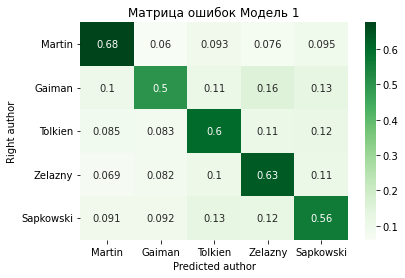

In [ ]:
plot_confusion_matrix(confusion, classes=authors_names, normalize=True, title='Матрица ошибок Модель 1')

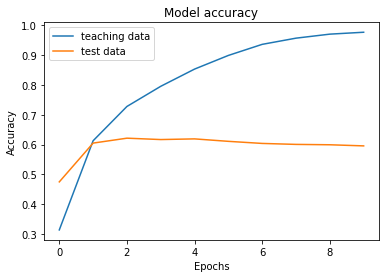

In [ ]:
plot_history_of_accurancy(gram3_model_history)

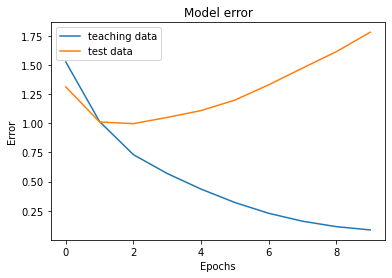

In [ ]:
plot_history_of_loss(gram3_model_history)

In [ ]:
def define_model2(input_len: int, output_size: int, vocab_size: int, embedding_dim: int, verbose: bool = True,
                drop_out_pct: float = 0.25, conv_filters: int = 500, activation_fn: str = 'relu', pool_size:int = 2, learning: float = 0.0001):
    
    inputs1 = Input(shape=(input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters=conv_filters, kernel_size=3, activation=activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size=pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    inputs2 = Input(shape=(input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters=conv_filters, kernel_size=4, activation=activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size=pool_size)(conv2)
    flat2 = Flatten()(pool2)

    inputs3 = Input(shape=(input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters=conv_filters, kernel_size=5, activation=activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size=pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    inputs4 = Input(shape=(input_len,))
    embedding4 = Embedding(vocab_size, embedding_dim)(inputs4)
    drop4 = Dropout(drop_out_pct)(embedding4)
    conv4 = Conv1D(filters=conv_filters, kernel_size=6, activation=activation_fn)(drop4)
    pool4 = MaxPooling1D(pool_size=pool_size)(conv4)
    flat4 = Flatten()(pool4)
    
    merged = concatenate([flat1, flat2, flat3, flat4])
    
    output = Dense(output_size, activation='softmax')(merged)
    
    model = Model(inputs = [inputs1, inputs2, inputs3, inputs4], outputs = output)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [ ]:
t0 = time.time()
gram3_model2 = define_model2(350, authors_count, max_3gram + 1, 600)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 350)]        0                                            
____________________________________________________________________________________________

In [ ]:
gram3_model2_history = gram3_model2.fit([gram3_train, gram3_train, gram3_train, gram3_train], author_train_hot, epochs=10, batch_size=32, verbose=1, validation_split=0.2)
t1 = time.time()

Epoch 1/10
1000/1000 [==============================] - 78s 78ms/step - loss: 1.5104 - accuracy: 0.3305 - val_loss: 1.2279 - val_accuracy: 0.5281
Epoch 2/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.9660 - accuracy: 0.6277 - val_loss: 0.9993 - val_accuracy: 0.6106
Epoch 3/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.6885 - accuracy: 0.7472 - val_loss: 1.0022 - val_accuracy: 0.6210
Epoch 4/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.5096 - accuracy: 0.8221 - val_loss: 1.0660 - val_accuracy: 0.6127
Epoch 5/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.3614 - accuracy: 0.8836 - val_loss: 1.1446 - val_accuracy: 0.6139
Epoch 6/10
1000/1000 [==============================] - 77s 77ms/step - loss: 0.2438 - accuracy: 0.9298 - val_loss: 1.2729 - val_accuracy: 0.6104
Epoch 7/10
1000/1000 [==============================] - 77s 77ms/step - loss: 0.1607 - accuracy: 0.9576 - val_loss: 1.4199 -

Статистика для второй 3-грамм модели.

In [ ]:
author_pred2 = gram3_model2.predict([gram3_test, gram3_test, gram3_test, gram3_test])

t2 = time.time()

author_pred2 = author_lb.inverse_transform(author_pred2)

accuracy = accuracy_score(author_test, author_pred2)
precision, recall, f1, support=score(author_test, author_pred2)
ave_precision = np.average(precision, weights=support/np.sum(support))
ave_recall = np.average(recall, weights=support/np.sum(support))
ave_f1 = np.average(f1, weights=support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred2, labels=authors_names)
    
print('Accuracy:', accuracy)
print('Average Precision:', ave_precision)
print('Average Recall:', ave_recall)
print('Average F1 Score:', ave_f1)
print('Learning time:', (t1 - t0), 'секунд')
print('Predict time:', (t2 - t1), 'секунд')
print('Confusion matrix:\n', confusion)

Accuracy: 0.5975
Average Precision: 0.5992085171792201
Average Recall: 0.5974999999999999
Average F1 Score: 0.5976984427392338
Learning time: 806.9759614467621 секунд
Predict time: 376.9495553970337 секунд
Confusion matrix:
 [[1350  162  167  129  203]
 [ 185 1103  180  233  305]
 [ 168  199 1126  192  286]
 [ 144  202  196 1183  275]
 [ 166  212  224  197 1213]]


Normalized confusion matrix
[[0.67130781 0.08055694 0.08304326 0.06414719 0.1009448 ]
 [0.09222333 0.54985045 0.08973081 0.11615155 0.15204387]
 [0.08523592 0.10096398 0.57128361 0.09741248 0.14510401]
 [0.072      0.101      0.098      0.5915     0.1375    ]
 [0.08250497 0.10536779 0.11133201 0.09791252 0.6028827 ]]


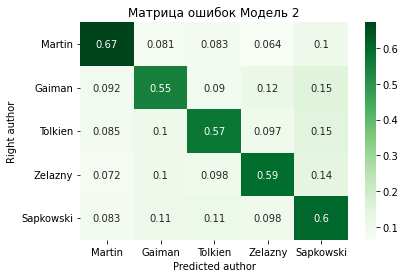

In [ ]:
plot_confusion_matrix(confusion, classes=authors_names, normalize=True, title='Матрица ошибок Модель 2')

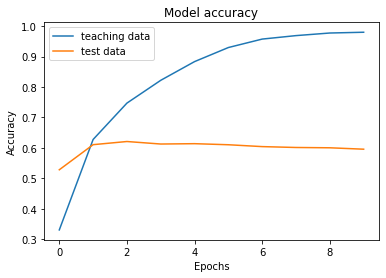

In [ ]:
plot_history_of_accurancy(gram3_model2_history)

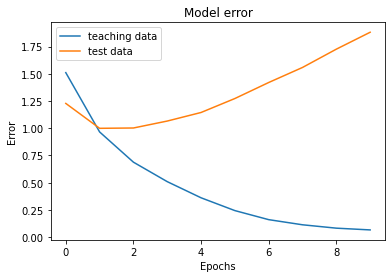

In [ ]:
plot_history_of_loss(gram3_model2_history)

In [ ]:
accuracy_list = []
prec_list = []
recall_list = []
f1_list = []

for i in range(10):
    author_pred3 = np.random.choice(authors_names, len(author_test))

    accuracy = accuracy_score(author_test, author_pred3)
    precision, recall, f1, support = score(author_test, author_pred3)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print('Accuracy:', accuracy_list, np.mean(accuracy_list), np.std(accuracy_list))
print('Average Precision:', prec_list, np.mean(prec_list), np.std(prec_list))
print('Average Recall:', recall_list, np.mean(recall_list), np.std(recall_list))
print('Average F1 Score:', f1_list, np.mean(f1_list), np.std(f1_list))

Accuracy: [0.2014, 0.2005, 0.2, 0.2014, 0.1969, 0.1971, 0.2015, 0.1929, 0.1996, 0.2067] 0.19979999999999998 0.003456877203488724
Average Precision: [0.20149068277967885, 0.20054384411718854, 0.19994307930611038, 0.20127548516060115, 0.19707475231129049, 0.1970871957360245, 0.2015374598569453, 0.19291115201034803, 0.19957425733938106, 0.2066565497933981] 0.19980944584109664 0.003434135384295279
Average Recall: [0.2014, 0.2005, 0.19999999999999998, 0.20140000000000002, 0.19690000000000002, 0.1971, 0.20149999999999998, 0.1929, 0.1996, 0.2067] 0.19979999999999998 0.0034568772034887212
Average F1 Score: [0.20141031505602447, 0.20050801808896287, 0.19996782695673151, 0.20130438184844215, 0.1969638825866971, 0.19706726515139278, 0.2015104424194626, 0.19287691884950867, 0.19958397949926507, 0.20667330270719042] 0.19978663331636776 0.0034502024683748514


Теперь самое интересное. После всех выполненных действий у нас есть два предсказания. Мы вызываем предложение, у нас обозначен его истинный автор. Также мы смотрим на то, как наши модели предсказывают авторство предложения.

In [ ]:
for i in range(20):
    print('Предложение', i, '- Верный ответ =', author_test[i],  'Предсказание Модели 1 =', author_pred1[i], 'Предсказание Модели 2 =', author_pred2[i])
    print(text_test[i], '\n')

Предложение 0 - Верный ответ = Gaiman Предсказание Модели 1 = Sapkowski Предсказание Модели 2 = Sapkowski
геродота 

Предложение 1 - Верный ответ = Sapkowski Предсказание Модели 1 = Sapkowski Предсказание Модели 2 = Gaiman
держи рот на замке и не встревай 

Предложение 2 - Верный ответ = Martin Предсказание Модели 1 = Martin Предсказание Модели 2 = Martin
с ним был сир марк пайпер они привели сына сира реймена дарри парнишку не старше брана 

Предложение 3 - Верный ответ = Gaiman Предсказание Модели 1 = Tolkien Предсказание Модели 2 = Sapkowski
я слышал чейто голос 

Предложение 4 - Верный ответ = Sapkowski Предсказание Модели 1 = Gaiman Предсказание Модели 2 = Gaiman
и не крутили задом у мужчин перед глазами  

Предложение 5 - Верный ответ = Sapkowski Предсказание Модели 1 = Sapkowski Предсказание Модели 2 = Sapkowski
 тебе не уехать геральт  

Предложение 6 - Верный ответ = Tolkien Предсказание Модели 1 = Tolkien Предсказание Модели 2 = Tolkien
я сразу же покинул дэнетора но еще по д

# Итог

Как мы можем видеть, наши модели умеют предсказывать заданные предложения. Где-то предсказание получается сразу, где-то только на второй модели, а где-то авторство предсказывается неправильно ни в одной из моделей. 

Таким образом, с помощью n-грамм мы обучили модель определять авторство текста по предложению, хоть модель и содержит в себе множество ошибок и иногда предсказывает неверно. Цели достигнуты, задачи выполнены.

# Способ 2

# Стемминг и векторные представления: логистическая регрессия

Для начала возьмем наш необработанный датасет и скопируем его, присвоив ему новое имя для того, чтобы случайно не переписать исходные данные.

In [ ]:
import shutil
shutil.copy2('/kaggle/working/data.csv', '/kaggle/working/data_stemming.csv')

'/kaggle/working/data_stemming.csv'

Испортируем новый датасет, аналогичный исходному.

In [ ]:
data_stem = pd.read_csv('data_stemming.csv', encoding='utf8')
print(data_stem.head())
print(data_stem.tail())

                                                text   author
0  Тысячи лет пираты с Железных Островов — железн...   Martin
1  И на сей раз на него нахлынул приступ ярости, ...   Gaiman
2                                  И ответа не было.   Gaiman
3  Любопытство мое было подогрето до такой степен...  Tolkien
4       Пламя лизало камень злыми красными язычками.   Martin
                                                    text   author
49995  Потом я разглядел, что у нее в левой руке, и б...  Zelazny
49996                      Знал, наверное, еще как знал!  Tolkien
49997  Он вытер руки о джинсы и протянул Тени могучую...   Gaiman
49998            А потом сказала с неуверенной улыбкой:.   Gaiman
49999  Кто-то заметил на дереве краснохвостого ястреб...   Gaiman


Устанавливаем необходимые библиотеки.

In [ ]:
!pip install pymorphy2
import pandas as pd
import numpy as np
import nltk
import re
import csv
from nltk.stem import WordNetLemmatizer
import sklearn
import codecs
import pymorphy2
import seaborn as sns
sns.set_style("darkgrid")
from nltk.stem.snowball import SnowballStemmer

Импортируем стоп-слова из NLTK.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Даже несмотря на то, что изначальный датасет у нас содержит в себе предложения не более чем из 5 слов, для дальнейшей обработки текста нам все равно нужны стоп-слова, чтобы убрать их из уже существующих предложений.

Мы будем делать стемминг слов при условии, что слов не находится в списке стоп-слов.

In [ ]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('russian'))

def data_stem_prep(text):  
    reg = re.compile('[^а-яА-яa-zA-Z0-9 ]')
    text = text.lower().replace("ё", "е")
    text = text.replace("ъ", "ь")
    text = text.replace("й", "и")
    text = reg.sub(' ', text)
    
    stemmer = SnowballStemmer("russian")
    
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stopWords])

    return text

Очистим наш текст.

In [ ]:
data_stem['text'] = data_stem['text'].apply(data_stem_prep)

Выведем полученное.

In [ ]:
print(data_stem.head())
print(data_stem.tail())

                                                text   author
0  тысяч лет пират железн остров железн людьм наз...   Martin
1  се нахлынул приступ ярост глухо темны собра ку...   Gaiman
2                                              ответ   Gaiman
3  любопытств мо подогрет тако степен последова н...  Tolkien
4                   плам лиза камен злым красн язычк   Martin
                                                    text   author
49995            разглядел лево рук быстр посмотрел джул  Zelazny
49996                                   знал наверн знал  Tolkien
49997  вытер рук джинс протянул тен могуч лапищ слыша...   Gaiman
49998                            сказа неуверенно улыбко   Gaiman
49999  замет дерев краснохв ястреб сказа эт скор соко...   Gaiman


Разбиваем датасет на выборки обучения и теста.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_stem['text'], data_stem['author'], test_size=.15, random_state=42)

Посмотрим на наши выборки обучения и теста.

In [ ]:
print(len(X_train), len(X_test))

42500 7500


Используем метод мешка слов.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

X_train_BOW = vectorizer.fit_transform(X_train)
X_test_BOW = vectorizer.transform(X_test)

In [ ]:
Ниже посмотрим на количество векторов в выборках и их размерность.

In [ ]:
print(X_train_BOW.shape, X_test_BOW.shape)

(42500, 28284) (7500, 28284)


Посмотрим на то, верно ли рассматривается количество элементов.

In [ ]:
X_train.iloc[200]

'горяч вод застав вспомн винтерфелл принесл сил'

In [ ]:
X_train_BOW[200]

<1x28284 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

Построим простую логистическую регрессию

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train_BOW, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Вычислим предсказания.

In [ ]:
y_predict_BOW = clf.predict(X_test_BOW)

Получаем метрику точности модели.

In [ ]:
accuracy_score(y_predict_BOW, y_test)

0.6752

Добавим в мешок слов биграммы для увеличения точности и посмотрим на метрику точности регрессии.

In [ ]:

vectorizer = CountVectorizer(ngram_range=(1, 2))

X_train_BOW_bi = vectorizer.fit_transform(X_train)
X_test_BOW_bi = vectorizer.transform(X_test)

print(X_train_BOW_bi.shape, X_test_BOW_bi.shape)

clf = LogisticRegression(random_state=0).fit(X_train_BOW_bi, y_train)

y_predict_BOW_bi = clf.predict(X_test_BOW_bi)

accuracy_score(y_predict_BOW_bi, y_test)

(42500, 246287) (7500, 246287)


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.6726666666666666

# Способ 3 

# Визуализация эмбеддингов для каждой книги

In [ ]:
!pip install spacy
!python -m spacy download ru_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 640.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 20.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')


Считаем эмбеддинги для "Американские боги" Н. Геймана.

In [ ]:
file_gaiman = open("/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Гейман Американские боги.txt", "rt")
data_gaiman = file_gaiman.read()
words_gaiman = data_gaiman.split()

print('Количество слов в книге:', len(words_gaiman))

Количество слов в книге: 180299


Время начала: 2023-01-22 21:00:21.098808


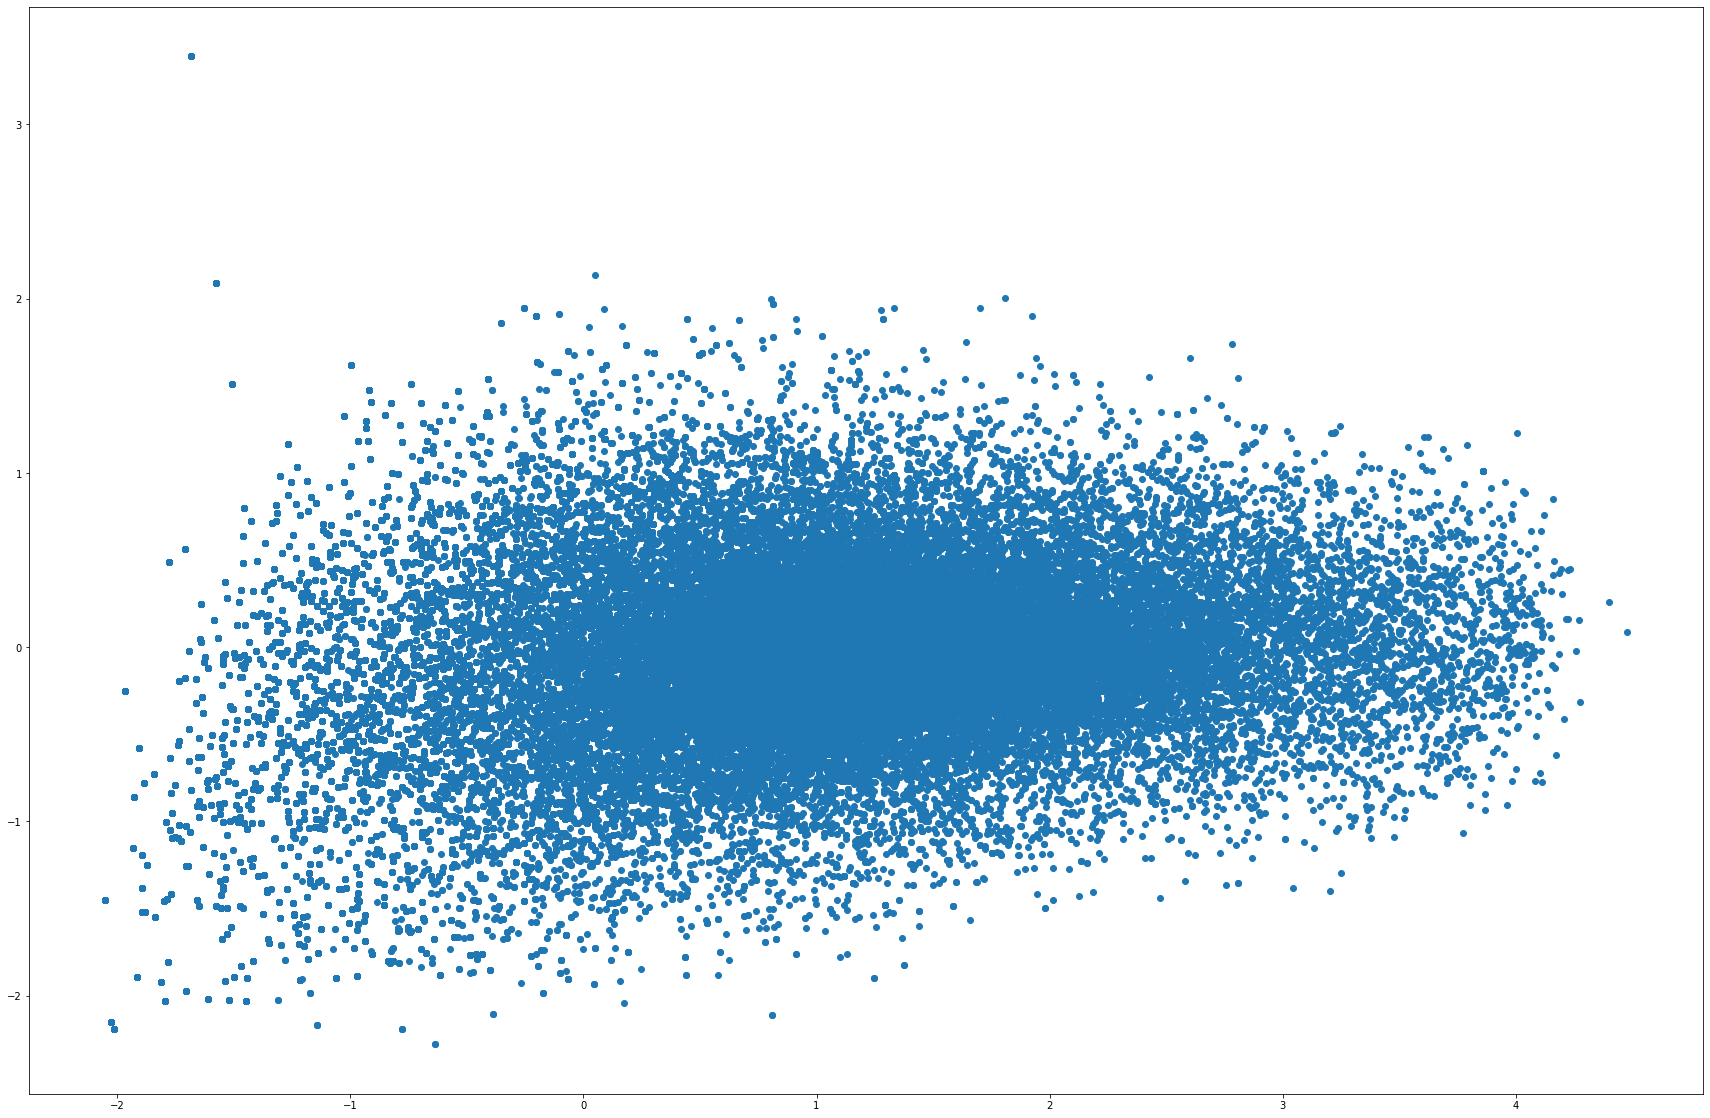

Время начала: 2023-01-22 21:00:21.098808
Время окончания: 2023-01-22 21:09:20.000910


In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import spacy
from datetime import datetime

start_parse_date = datetime.now()
print(f"Время начала: {start_parse_date}")

nlp = spacy.load("ru_core_news_lg")

def reduce_dimensions(vectors, explained_var=0.99, method="PCA"):
    if method == "PCA":
        pca = PCA(n_components=3)
    else:
        return None

    pca_vec = pca.fit_transform(vectors)

    for i, s in enumerate(np.cumsum(pca.explained_variance_ratio_)):
        if s > explained_var:
            break

    return pca_vec[:, :i]

def plot(vec, xi=0, yi=1):
    plt.figure(figsize=(30, 20) )
    ax = plt.gca()
    x = vec[:, xi]
    y = vec[:, yi]
    ax.scatter(x, y)
    plt.show()
    plt.close()


with open(r"/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Гейман Американские боги.txt", "r", encoding="utf-8") as file:
    test_sentence = file.read()

test_sentence = test_sentence.split()

vectors = [nlp(text, disable=['parser', 'tagger', 'ner']).vector for text in test_sentence]

vec1 = reduce_dimensions(vectors)
plot(vec1)

end_parse_date = datetime.now()
print(f"Время начала: {start_parse_date}")
print(f"Время окончания: {end_parse_date}")

Считаем эмбеддинги для "Хроники Амбера" Р. Желязны.

In [ ]:
file_zelazny = open("/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Желязны Хроники Амбера.txt", "rt")
data_zelazny = file_zelazny.read()
words_zelazny = data_zelazny.split()

print('Количество слов в книге:', len(words_zelazny))

Количество слов в книге: 303078


Время начала: 2023-01-22 21:11:36.573349


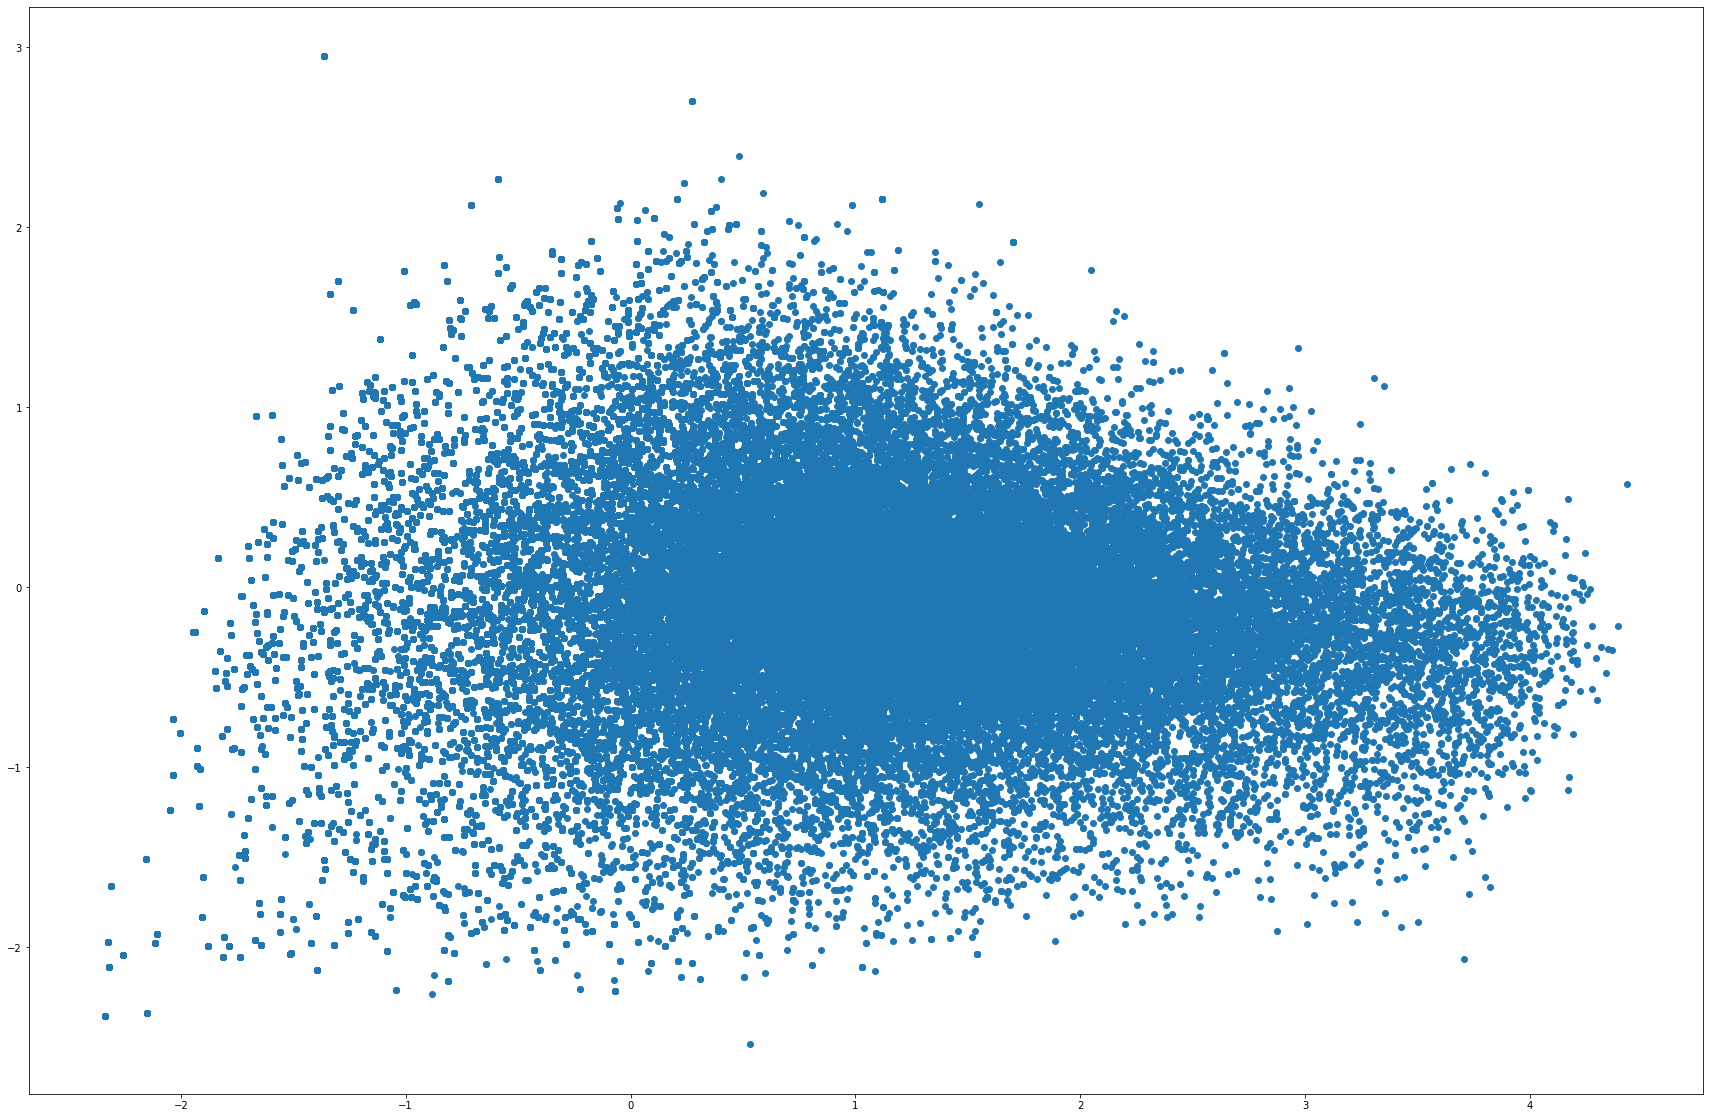

Время начала: 2023-01-22 21:11:36.573349
Время окончания: 2023-01-22 21:26:33.176794


In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import spacy
from datetime import datetime

start_parse_date = datetime.now()
print(f"Время начала: {start_parse_date}")

nlp = spacy.load("ru_core_news_lg")

def reduce_dimensions(vectors, explained_var=0.99, method="PCA"):
    if method == "PCA":
        pca = PCA(n_components=3)
    else:
        return None

    pca_vec = pca.fit_transform(vectors)

    for i, s in enumerate(np.cumsum(pca.explained_variance_ratio_)):
        if s > explained_var:
            break

    return pca_vec[:, :i]

def plot(vec, xi=0, yi=1):
    plt.figure(figsize=(30, 20) )
    ax = plt.gca()
    x = vec[:, xi]
    y = vec[:, yi]
    ax.scatter(x, y)
    plt.show()
    plt.close()


with open(r"/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Желязны Хроники Амбера.txt", "r", encoding="utf-8") as file:
    test_sentence = file.read()

test_sentence = test_sentence.split()

vectors = [nlp(text, disable=['parser', 'tagger', 'ner']).vector for text in test_sentence]

vec1 = reduce_dimensions(vectors)
plot(vec1)

end_parse_date = datetime.now()
print(f"Время начала: {start_parse_date}")
print(f"Время окончания: {end_parse_date}")

Считаем эмбеддинги для "Игра престолов" Дж. Мартина.

In [ ]:
file_martin = open("/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Мартин Игра престолов.txt", "rt")
data_martin = file_martin.read()
words_martin = data_martin.split()

print('Количество слов в книге:', len(words_martin))

Количество слов в книге: 253961


Время начала: 2023-01-22 21:27:49.703321


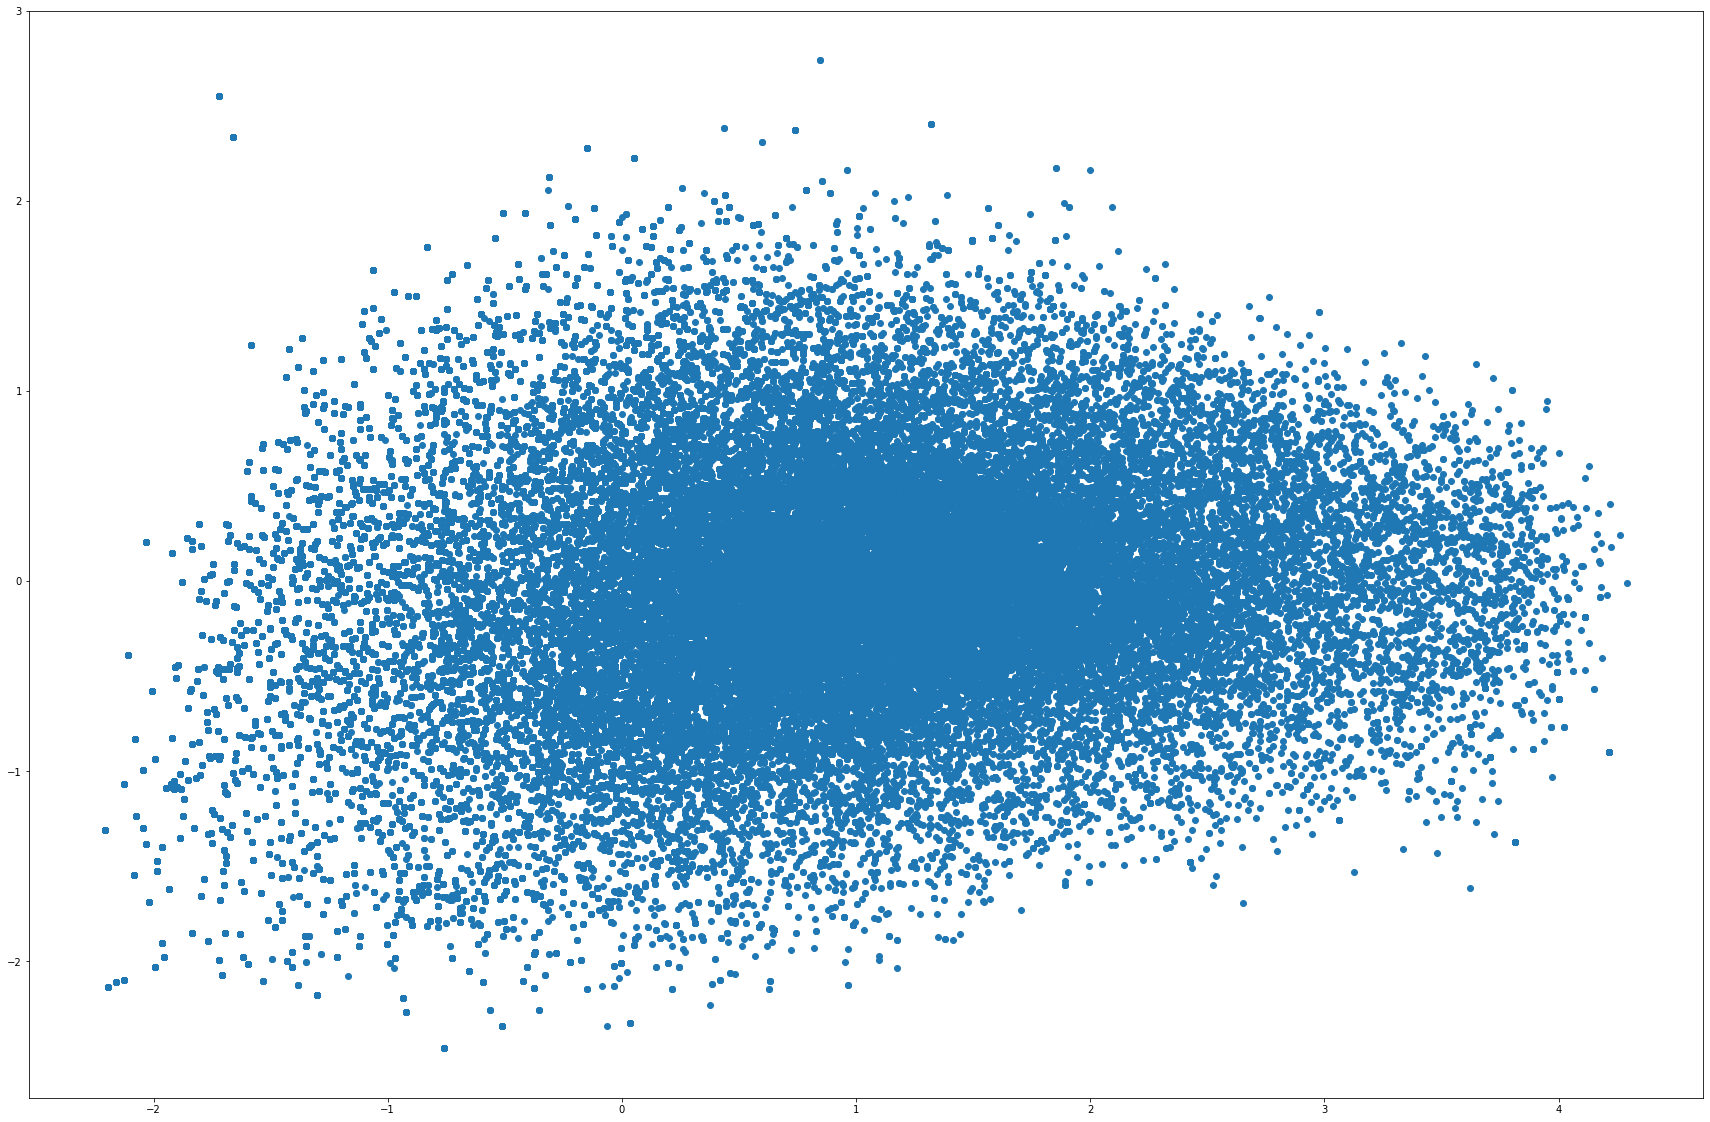

Время начала: 2023-01-22 21:27:49.703321
Время окончания: 2023-01-22 21:40:23.490132


In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import spacy
from datetime import datetime

start_parse_date = datetime.now()
print(f"Время начала: {start_parse_date}")

nlp = spacy.load("ru_core_news_lg")

def reduce_dimensions(vectors, explained_var=0.99, method="PCA"):
    if method == "PCA":
        pca = PCA(n_components=3)
    else:
        return None

    pca_vec = pca.fit_transform(vectors)

    for i, s in enumerate(np.cumsum(pca.explained_variance_ratio_)):
        if s > explained_var:
            break

    return pca_vec[:, :i]

def plot(vec, xi=0, yi=1):
    plt.figure(figsize=(30, 20) )
    ax = plt.gca()
    x = vec[:, xi]
    y = vec[:, yi]
    ax.scatter(x, y)
    plt.show()
    plt.close()


with open(r"/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Мартин Игра престолов.txt", "r", encoding="utf-8") as file:
    test_sentence = file.read()

test_sentence = test_sentence.split()

vectors = [nlp(text, disable=['parser', 'tagger', 'ner']).vector for text in test_sentence]

vec1 = reduce_dimensions(vectors)
plot(vec1)

end_parse_date = datetime.now()
print(f"Время начала: {start_parse_date}")
print(f"Время окончания: {end_parse_date}")

Считаем эмбеддинги для "Последнее желание. Меч предназначения" А. Сапковского.

In [ ]:
file_sapkowski = open("/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Сапковский Последнее желание Меч предназначения.txt", "rt")
data_sapkowski = file_sapkowski.read()
words_sapkowski = data_sapkowski.split()

print('Количество слов в книге:', len(words_sapkowski))

Количество слов в книге: 171119


Время начала: 2023-01-22 21:41:18.962586


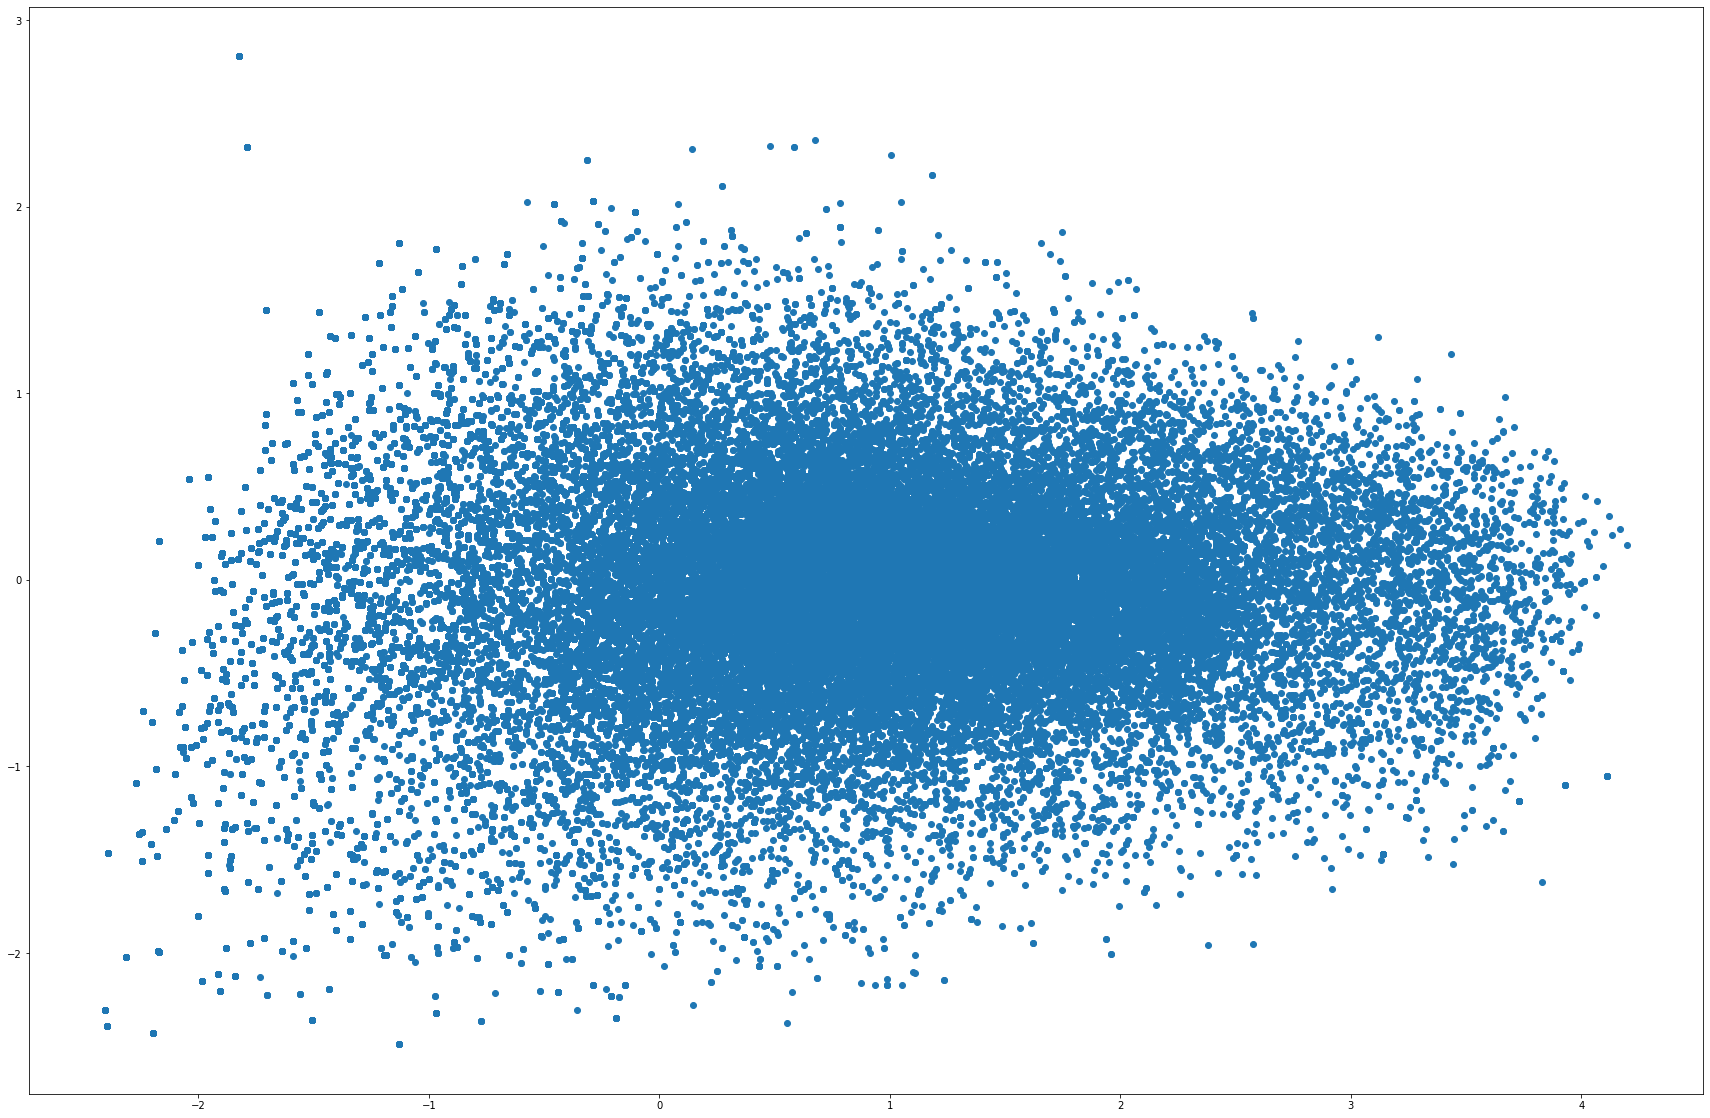

Время начала: 2023-01-22 21:41:18.962586
Время окончания: 2023-01-22 21:49:43.904536


In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import spacy
from datetime import datetime

start_parse_date = datetime.now()
print(f"Время начала: {start_parse_date}")

nlp = spacy.load("ru_core_news_lg")

def reduce_dimensions(vectors, explained_var=0.99, method="PCA"):
    if method == "PCA":
        pca = PCA(n_components=3)
    else:
        return None

    pca_vec = pca.fit_transform(vectors)

    for i, s in enumerate(np.cumsum(pca.explained_variance_ratio_)):
        if s > explained_var:
            break

    return pca_vec[:, :i]

def plot(vec, xi=0, yi=1):
    plt.figure(figsize=(30, 20) )
    ax = plt.gca()
    x = vec[:, xi]
    y = vec[:, yi]
    ax.scatter(x, y)
    plt.show()
    plt.close()


with open(r"/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Сапковский Последнее желание Меч предназначения.txt", "r", encoding="utf-8") as file:
    test_sentence = file.read()

test_sentence = test_sentence.split()

vectors = [nlp(text, disable=['parser', 'tagger', 'ner']).vector for text in test_sentence]

vec1 = reduce_dimensions(vectors)
plot(vec1)

end_parse_date = datetime.now()
print(f"Время начала: {start_parse_date}")
print(f"Время окончания: {end_parse_date}")

Считаем эмбеддинги для "Властелин колец" Дж. Р. Р. Толкина.

In [ ]:
file_tolkien = open("/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Толкин Властелин колец.txt", "rt")
data_tolkien = file_tolkien.read()
words_tolkien = data_tolkien.split()

print('Количество слов в книге:', len(words_tolkien))

Количество слов в книге: 436069


Время начала: 2023-01-22 21:55:02.520434


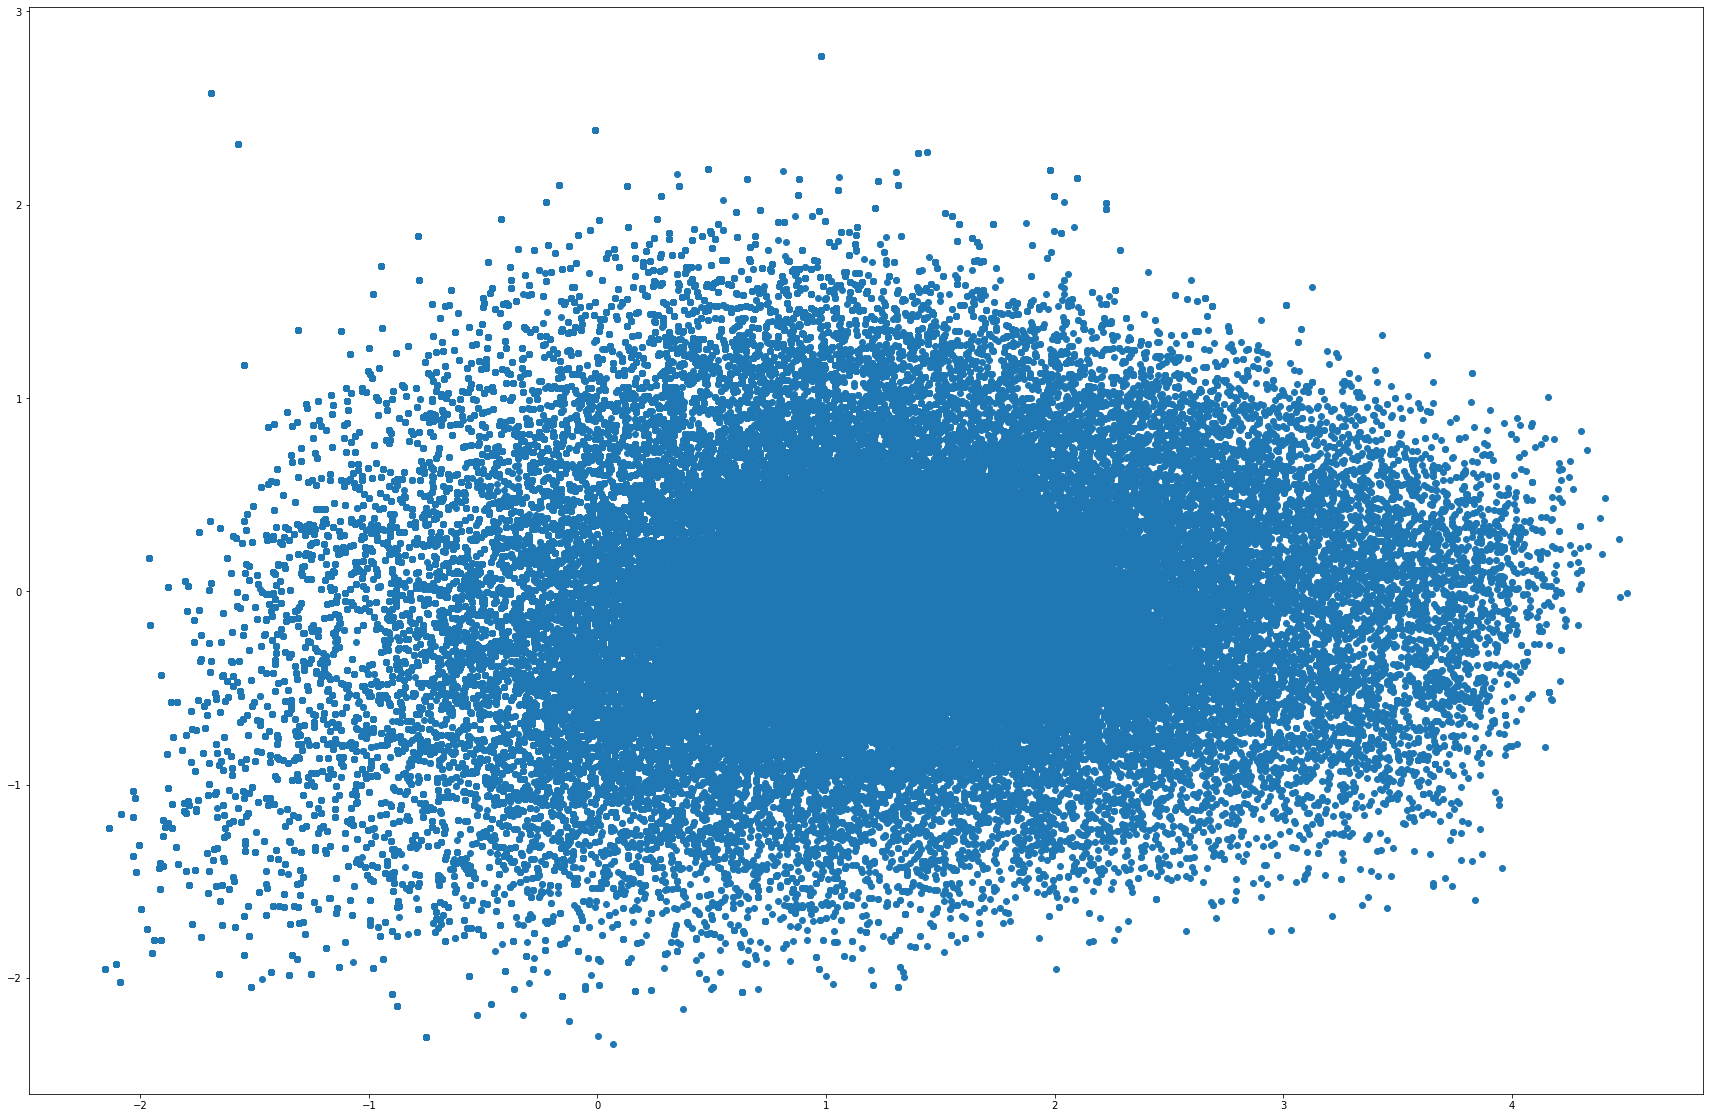

Время начала: 2023-01-22 21:55:02.520434
Время окончания: 2023-01-22 22:15:20.848591


In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import spacy
from datetime import datetime

start_parse_date = datetime.now()
print(f"Время начала: {start_parse_date}")

nlp = spacy.load("ru_core_news_lg")

def reduce_dimensions(vectors, explained_var=0.99, method="PCA"):
    if method == "PCA":
        pca = PCA(n_components=3)
    else:
        return None

    pca_vec = pca.fit_transform(vectors)

    for i, s in enumerate(np.cumsum(pca.explained_variance_ratio_)):
        if s > explained_var:
            break

    return pca_vec[:, :i]

def plot(vec, xi=0, yi=1):
    plt.figure(figsize=(30, 20) )
    ax = plt.gca()
    x = vec[:, xi]
    y = vec[:, yi]
    ax.scatter(x, y)
    plt.show()
    plt.close()


with open(r"/kaggle/input/d/azaze11oo/fantasy-data/фэнтези/Толкин Властелин колец.txt", "r", encoding="utf-8") as file:
    test_sentence = file.read()

test_sentence = test_sentence.split()

vectors = [nlp(text, disable=['parser', 'tagger', 'ner']).vector for text in test_sentence]

vec1 = reduce_dimensions(vectors)
plot(vec1)

end_parse_date = datetime.now()
print(f"Время начала: {start_parse_date}")
print(f"Время окончания: {end_parse_date}")